# 08 Example - Optimization Scan using `scipy.minimize` with Nelder-Mead Method

In [1]:
import pyscan as ps
import numpy as np
import matplotlib.pyplot as plt
from time import sleep
from functools import partial
from scipy.optimize import minimize

## Setup devices

In [ ]:
devices = ps.ItemAttribute()

devices.v1 = ps.TestVoltage() # Device 1
devices.v2 = ps.TestVoltage() # Device 2

## Define measure function

In [3]:
def voltage_response(v1, v2):
        return (v1 - 4)**2 + (v2 - 6)**2

def get_voltage_data(expt):
    """
    Reads the voltage from v1, v2, and v3 devices. Also adds a calculated value vsum.
    """

    runinfo = expt.runinfo
    devices = expt.devices

    d = ps.ItemAttribute()

    d.v1_readout = devices.v1.voltage
    d.v2_readout = devices.v2.voltage

    d.vf = voltage_response(d.v1_readout, d.v2_readout)
    
    return d

## Define live plot

In [4]:
@ps.live_plot
def plot_optim_live(expt):
    global fig, ax, cb0, cb1
    x, y = np.mgrid[0:10:.01, 0:10:.01]
    z = np.array(voltage_response(np.ravel(x), np.ravel(y)))
    z = z.reshape(x.shape)
    pcm = ax.pcolormesh(x, y, z, cmap='gist_heat')
    scatter = ax.scatter(expt.v1_readout, expt.v2_readout, c=range(len(expt.v1_readout)),
                cmap='viridis')
    ax.set_box_aspect(1)
    if cb0 is None and cb1 is None:
        cb0 = fig.colorbar(scatter, label="optimizer step")
        cb1 = fig.colorbar(pcm, label="voltage response")
    else:
        cb0.update_normal(scatter)
    ax.legend(["optimizer decision process",], loc='lower left', bbox_to_anchor=(.1, -.3))
    ax.set_xlabel("v1_readout")
    ax.set_ylabel("v2_readout")
    ax.set_title("Optimization of Voltage Response")

## Define runinfo

In [5]:
runinfo = ps.RunInfo()
runinfo.measure_function = get_voltage_data

## Define control function for optimization experiment

In [6]:
control_f = partial(minimize, x0=np.array([2., 1.]), method='Nelder-Mead', bounds=((0, 10), (0, 10)),
                    options={'maxfev': 100, 'fatol': .1})

## Define scan

In [7]:
runinfo.scan0 = ps.OptimizeFunctionalScan(('v1', 'v2'), 'voltage', 100,
                                          dt=1.)

## Define and run experiments

In [8]:
expt = ps.OptimizeFunctionalExperiment(runinfo, devices, control_f, ('vf',), 'voltage',
                                       time=True)
expt.start_thread()

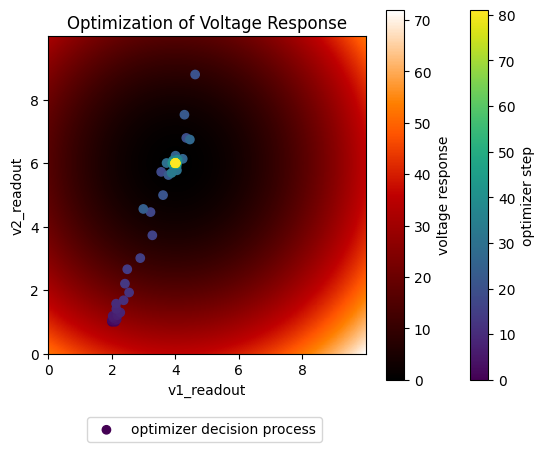

In [9]:
fig, ax = plt.subplots()
cb0 = cb1 = None
try:
    plot_optim_live(expt)
except KeyboardInterrupt:
    expt.stop()

In [10]:
# sleep(1) # wait for thread to finish

In [11]:
expt.__dict__

{'runinfo': <pyscan.measurement.run_info.RunInfo at 0x184911b82f0>,
 'devices': <pyscan.general.item_attribute.ItemAttribute at 0x184ffebfcb0>,
 'control_f': functools.partial(<function minimize at 0x00000184FFE56C00>, x0=array([2., 1.]), method='Nelder-Mead', bounds=((0, 10), (0, 10)), options={'maxfev': 100, 'fatol': 0.1}),
 'sample_f_outputs': ('vf',),
 'prop': 'voltage',
 'expt_thread': <Thread(Thread-3 (run), stopped daemon 34352)>,
 'v1_voltage': array([2.        , 2.1       , 2.        , 2.1       , 2.15      ,
        2.05      , 2.025     , 2.175     , 2.2625    , 2.1375    ,
        2.13125   , 2.36875   , 2.540625  , 2.409375  , 2.4828125 ,
        2.8921875 , 3.27265625, 3.21484375, 3.55195312, 4.34179687,
        4.62109375, 3.60976562, 4.28398437, 3.77832031, 2.98847656,
        4.0034668 , 4.22983398, 4.45498047, 3.94748535, 3.72111816,
        4.10265503, 4.04667358, 4.03587189, 3.88070221, 4.04716682,
        3.95878029, 3.92023449, 4.05846176, 3.97522945, 4.03071766,


In [12]:
# ps.live_plot2D(expt, data_name="vf") # TODO: remove empty values from v1_voltage and v2_voltage

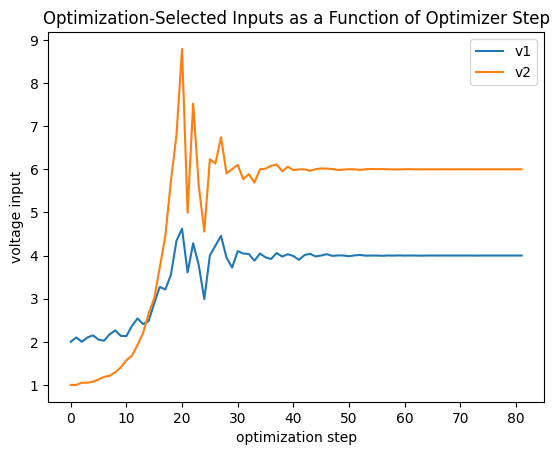

In [13]:
plt.plot(list(zip(expt.v1_readout, expt.v2_readout)))
plt.legend(['v1', 'v2'])
plt.xlabel("optimization step")
plt.ylabel("voltage input")
plt.title("Optimization-Selected Inputs as a Function of Optimizer Step");

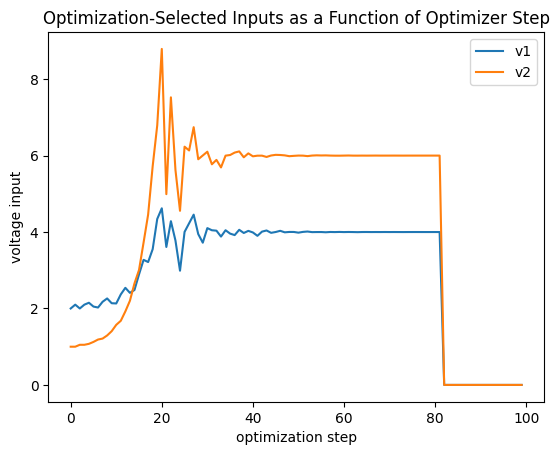

In [14]:
plt.plot(list(zip(expt.v1_voltage, expt.v2_voltage))) # TODO: trim unused inputs from scan dict?
plt.legend(['v1', 'v2'])
plt.xlabel("optimization step")
plt.ylabel("voltage input")
plt.title("Optimization-Selected Inputs as a Function of Optimizer Step");

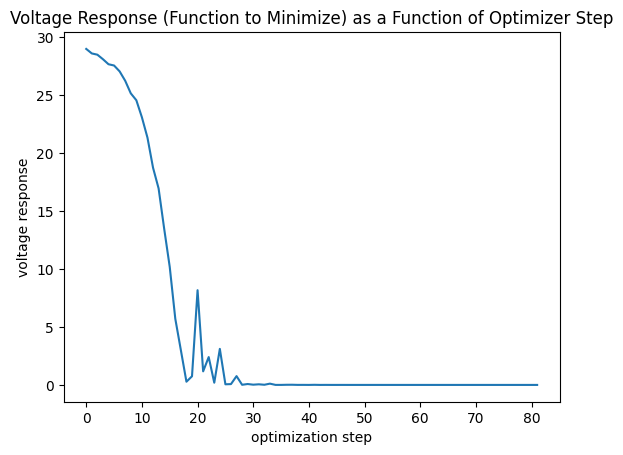

In [15]:
plt.plot(expt.vf)
plt.xlabel("optimization step")
plt.ylabel("voltage response")
plt.title("Voltage Response (Function to Minimize) as a Function of Optimizer Step");

In [16]:
def plot_optim_pcm():
    fig, ax = plt.subplots()
    x, y = np.mgrid[0:10:.01, 0:10:.01]
    z = np.array(voltage_response(np.ravel(x), np.ravel(y)))
    z = z.reshape(x.shape)
    pcm = ax.pcolormesh(x, y, z, cmap='gist_heat')
    scatter = ax.scatter(expt.v1_readout, expt.v2_readout, c=range(len(expt.v1_readout)),
                         cmap='viridis')
    ax.set_box_aspect(1)
    fig.colorbar(scatter, label="optimizer step")
    fig.colorbar(pcm, label="voltage response")
    ax.legend(["optimizer decision process",], loc='lower left', bbox_to_anchor=(.1, -.3))
    ax.set_xlabel("v1_readout")
    ax.set_ylabel("v2_readout")
    ax.set_title("Optimization of Voltage Response")

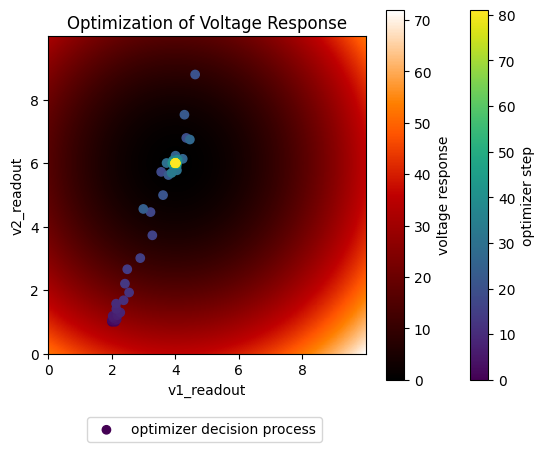

In [17]:
plot_optim_pcm()

In [18]:
def plot_optim_3d(elevation, azimuth):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    x, y = np.mgrid[0:10:.01, 0:10:.01]
    z = np.array(voltage_response(np.ravel(x), np.ravel(y)))
    z = z.reshape(x.shape)
    ax.plot_surface(x, y, z, color='C1', alpha=.5)
    scatter = ax.scatter(expt.v1_readout, expt.v2_readout, expt.vf, c=range(len(expt.v1_readout)))
    ax.view_init(elev=elevation, azim=azimuth)
    fig.colorbar(scatter, label="optimizer step", pad=.1)
    ax.legend(["voltage response function", "optimizer decision process",], loc='lower left', bbox_to_anchor=(.2, -.2))
    ax.set_xlabel("v1_readout")
    ax.set_ylabel("v2_readout")
    ax.set_zlabel("voltage response")
    ax.set_title("Optimization of Voltage Response")

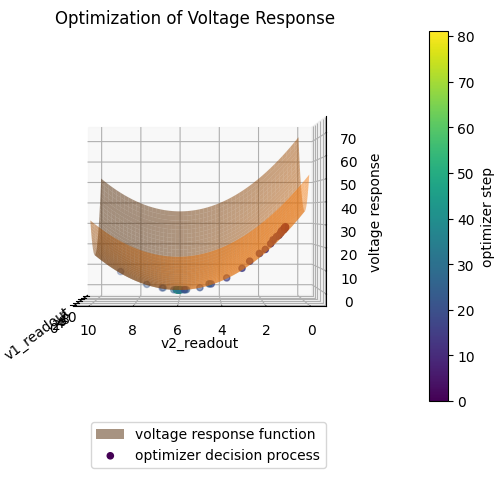

In [19]:
plot_optim_3d(0, 180)

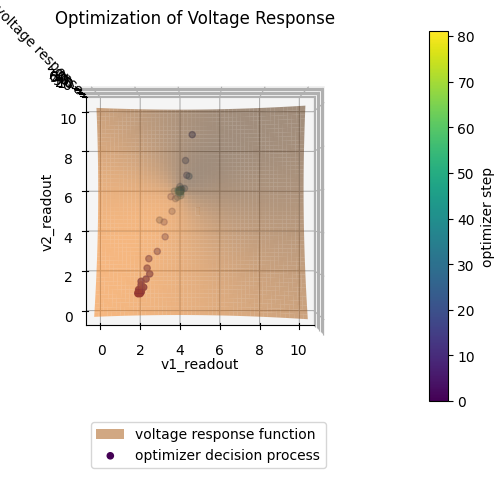

In [20]:
plot_optim_3d(90, 270)

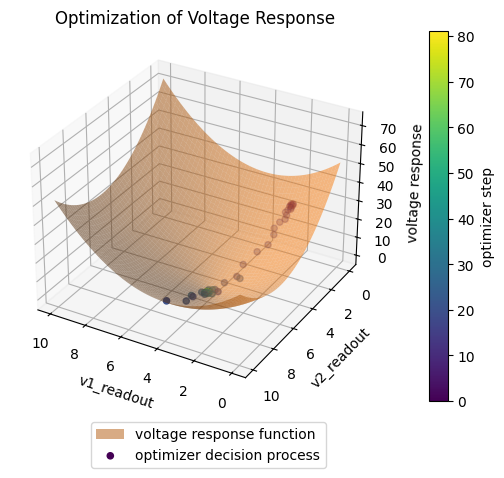

In [21]:
plot_optim_3d(30, 120)